In [3]:
#Some test to exxtract stanford dataset

In [1]:
import pandas as pd
import numpy as np

df_test = pd.read_csv("csvs/chunk5.csv")

#df_test.set_index('trace_name',inplace= True)

C:\Users\Andras\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3340: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
import librosa

In [3]:
import h5py
hf = h5py.File('chunk5.hdf5', 'r', libver='earliest')

In [ ]:
#eread = pd.read_hdf('chunk5.hdf5')

In [4]:
#hf['Folder'].attrs.keys()

ee = hf.get('data/HPC.NC_20130403221010_EV')


In [5]:
import matplotlib.pyplot as plt

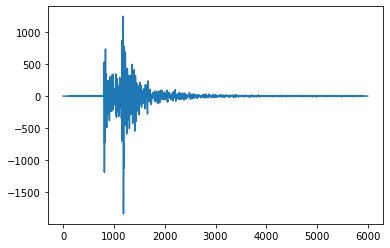

In [6]:
plt.plot(ee[:,2])

In [8]:
ee[:,2].shape

(6000,)

IndexError: tuple index out of range

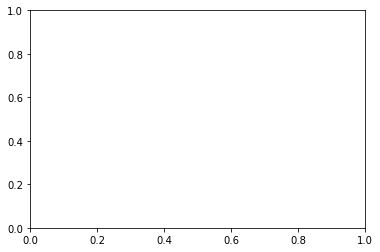

In [7]:
import librosa
import librosa.display
#TODO: convert to spectrogram
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(ee[:,2], ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                               y_axis='mel', sr=100,
                               fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [ ]:
plt.plot(ee[:,0])

In [ ]:
plt.plot(ee[:,1])

In [ ]:
ee.attrs.keys()

In [ ]:
df_test['time'] = pd.to_datetime(df_test['trace_start_time'], infer_datetime_format=True)
df_test['source_depth_km'] = pd.to_numeric(df_test['source_depth_km'],errors='coerce')
df_test['source_magnitude'] = pd.to_numeric(df_test['source_magnitude'],errors='coerce')
#df_test['source_magnitude'].sort_values()
#df_test.head(2)

In [ ]:
df_test = df_test[['time','source_depth_km','source_magnitude','trace_name','source_latitude','source_longitude','trace_category']]

In [ ]:
df_test

Extract the minimum depth, magnitude, recording times etcc

In [ ]:
#Latitudes and longitudes
site_lat = df_test.source_latitude
site_lon = df_test.source_longitude
hover_desc = 'Timestamp: ' +  str(df_test.time) + '<br>Category: ' + df_test.trace_category
#hover_desc = f'Time of registration: {df_earthquake_detections.trace_start_time} <br> Category: {df_earthquake_detections.trace_category}'
#time = df_earthquake_detections.trace_start_time
#ctg =df_earthquake_detections.trace_category
#locations_name = df.text
#min timestamp
#Extract timestamp range
min_date = min(df_test['time']).date()
max_date = max(df_test['time']).date()
#Extract minimum and maximum depth
min_depth = min(df_test['source_depth_km'])
max_depth = max(df_test['source_depth_km'])
#Extract minimum and maximum magnitude
min_magnitude = min(df_test['source_magnitude'])
max_magnitude = max(df_test['source_magnitude'])

depth_space = np.linspace(start=min_depth,stop=max_depth,num=8,endpoint=True,dtype=np.float64)
magnitude_space = np.linspace(start=min_magnitude,stop=max_magnitude,num=8,endpoint=True,dtype=np.float64)

In [ ]:
#df_earthquake_detections


In [ ]:
import base64
import plotly.graph_objects as go
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px

import dash_bootstrap_components as dbc
#from dash import  dash_table
import dash_table
from datetime import date
from dash.dependencies import Input,Output,State
from dash import callback_context
#https://plotly.com/python-api-reference/generated/plotly.graph_objects.Scattermapbox.html
#https://community.plotly.com/t/scattermapbox-setting-visible-range/6140/3
#mapbox_access_token = open(".mapbox_token").read()

#Mapbox map initialize
#fig = go.Figure({"layout": {
#    "title": "My Dash Graph",
#    "height": 700,  # px
#}})
#df = px.data.gapminder().query("year == 2007")
'''
fig = px.scatter_geo(df, locations="iso_alpha",
                     color="continent", # which column to use to set the color of markers
                     hover_name="country", # column added to hover information
                     size="pop", # size of markers
                     projection="natural earth")
'''


#!!!!!!!!!!!!!https://github.com/Coding-with-Adam/Dash-by-Plotly/blob/master/Dash_Interactive_Graphs/Scatter_mapbox/recycling.py
app = dash.Dash()


image_filename = 'samples_for_wireframe/img.png'
encoded_image = base64.b64encode(open(image_filename, 'rb').read())
#app.layout =html.Div([
app.layout = html.Div([dbc.Row([

                                #Filters
                                html.Div(style={'width':'20%','marginLeft': 5, 'marginRight': 10,'display':'inline-block',"border":"2px black solid"},
                                         children = [
                                            #html.Div([
                                            # dcc.Graph: maybe define somehow here?
                                            #dcc.Graph(figure=fig, id='map-layout')]),
                                             #'width':'15%','marginLeft': 20, 'marginRight': 20,
                                            html.Div(style={ 'display': 'block','vertical-align':'middle'},
                                                     children = [
                                                        html.Br(),
                                                        html.H3('Select a date interval'),
                                                        html.Br(),
                                                    #Datepicker to filter for intervals
                                                        dcc.DatePickerRange(
                                                            id='date-filter',
                                                            #min_date_allowed=date(1993, 1, 10),
                                                            min_date_allowed=min_date,
                                                            max_date_allowed=max_date,
                                                            #max_date_allowed=date(2019, 9, 19),
                                                            initial_visible_month=min_date,
                                                            start_date=min_date,
                                                            end_date=max_date
                                                        )]),
                                            #'width':'15%','marginLeft': 20, 'marginRight': 20,'marginTop':30,
                                            html.Div(
                                                style={ 'display': 'block','vertical-align':'middle'},
                                                children = [
                                                html.Br(),
                                                html.H3('Select earthquake depth interval ( in km)'),
                                                html.Br(),
                                                #slider to filter for depth
                                                dcc.RangeSlider(min = min_depth, max = max_depth,
                                                                id='depth-slider',
                                                                marks={i: '{:.2f}'.format(i) for i in depth_space},
                                                                value=[min_depth, max_depth],
                                                                dots=False,
                                                                #step=
                                                                step=0.01,
                                                                updatemode='drag',
                                                                tooltip={"placement": "bottom", "always_visible": False}
                                            )]),
                                             #'width':'15%','marginLeft': 20, 'marginRight': 20,'marginTop':30,
                                            html.Div(
                                                style={'display': 'block','vertical-align':'middle'},
                                                children = [
                                                html.Br(),
                                                html.H3('Select earthquake magnitude interval ( in km)'),
                                                html.Br(),
                                                #slider to filter for magnitudes
                                                dcc.RangeSlider(min = min_magnitude, max = max_magnitude,
                                                                id='magnitude-slider',
                                                                marks={i: '{:.2f}'.format(i) for i in magnitude_space},
                                                                value=[min_magnitude, max_magnitude],
                                                                dots=False,
                                                                step=0.01,
                                                                updatemode='drag',
                                                                tooltip={"placement": "bottom", "always_visible": False}
                                                                ),
                                                ]),
                                             html.Div(
                                                 style={'display': 'block','vertical-align':'middle'},
                                                 children = [
                                                             html.Button('Apply Filter', id='filter-apply-btn', n_clicks=0),
                                                             html.Button('Reset Filter', id='filter-reset-btn', n_clicks=0)]
                                             )
                                         ]),
                                #Map
                                html.Div(
                                        style={'width':'75%', 'marginRight': 5,'display':'inline-block',"border":"2px black solid"},
                                #children = [dcc.Graph(figure=fig, id='map-layout')])]),
                                        children = [ dash_table.DataTable(data = df_test.head(5).to_dict('records'),columns=[{"name": i, "id": i} for i in df_test.columns], id='tbl')])]
                                ),
                dbc.Row(html.Div([
                    #Audio player
                    html.Div(style={'width':'20%','marginLeft': 5,'marginTop': 20, 'marginRight': 20,'display':'inline-block',"border":"2px black solid"},
                             children = [html.Audio(src='samples_for_wireframe/HC1.wav', controls=True)]),
                    #Spectrogram
                    html.Div(style={'width':'75%', 'marginRight': 10 ,'marginTop': 20, 'display':'inline-block',"border":"2px black solid"},
                             #children = [html.Img(src='samples_for_wireframe/img.png')])]))])
                             children = [html.Img(src='data:image/png;base64,{}'.format(encoded_image.decode()))])]))])

@app.callback(
    Output(component_id='tbl', component_property='data'), #Output will be the table (later map)
    Output(component_id='depth-slider', component_property= 'value'),
    Output(component_id='magnitude-slider', component_property= 'value'),
    Output(component_id='date-filter', component_property= 'start_date'),
    Output(component_id='date-filter', component_property= 'end_date'),
    Input(component_id='filter-apply-btn', component_property='n_clicks'), #Input button triggers the callback
    Input(component_id='filter-reset-btn', component_property='n_clicks'), #Input button triggers the callback
    State(component_id='depth-slider', component_property= 'value'),
    State(component_id='magnitude-slider', component_property= 'value'),
    State(component_id='date-filter', component_property= 'start_date'),
    State(component_id='date-filter', component_property= 'end_date')

)
def apply_filter(apply_click,reset_click, depth_value, magnitude_value,start_date,end_date):
    ctx = dash.callback_context
    clicked_element = ctx.triggered[0]['prop_id'].split('.')[0]
    if  clicked_element == 'filter-apply-btn':
        filter_records = df_test['time'].between(pd.to_datetime(start_date),pd.to_datetime(end_date)) & df_test['source_magnitude'].between(magnitude_value[0],magnitude_value[1])\
                         & df_test['source_depth_km'].between(depth_value[0],depth_value[1])
        df_filtered = df_test[filter_records]

        return [df_filtered.head(5).to_dict('records'),depth_value,magnitude_value,start_date,end_date]

    elif clicked_element == 'filter-reset-btn':
        return [df_test.head(5).to_dict('records'),[min_depth,max_depth],[min_magnitude,max_magnitude],min_date,max_date]

    else:
        return dash.no_update


'''
selection of earthquake events on maps
First, selection in the table will be used as test for composition,
then refactor for map event selection
'''

app.run_server(debug=True, use_reloader=False)  # Turn off reloader if inside Jupyter


If we also want to load map, that need to be used